In [3]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import copy

from scipy import stats
from itertools import product
from collections import Counter, defaultdict, OrderedDict
from itertools import combinations, product
from tqdm import tqdm
from pprint import pprint

# sklearn
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.kernel_ridge import KernelRidge, pairwise_kernels

# matplotlib
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
%matplotlib inline

titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize
matplotlib.rcParams['figure.figsize'] = (10, 8)

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

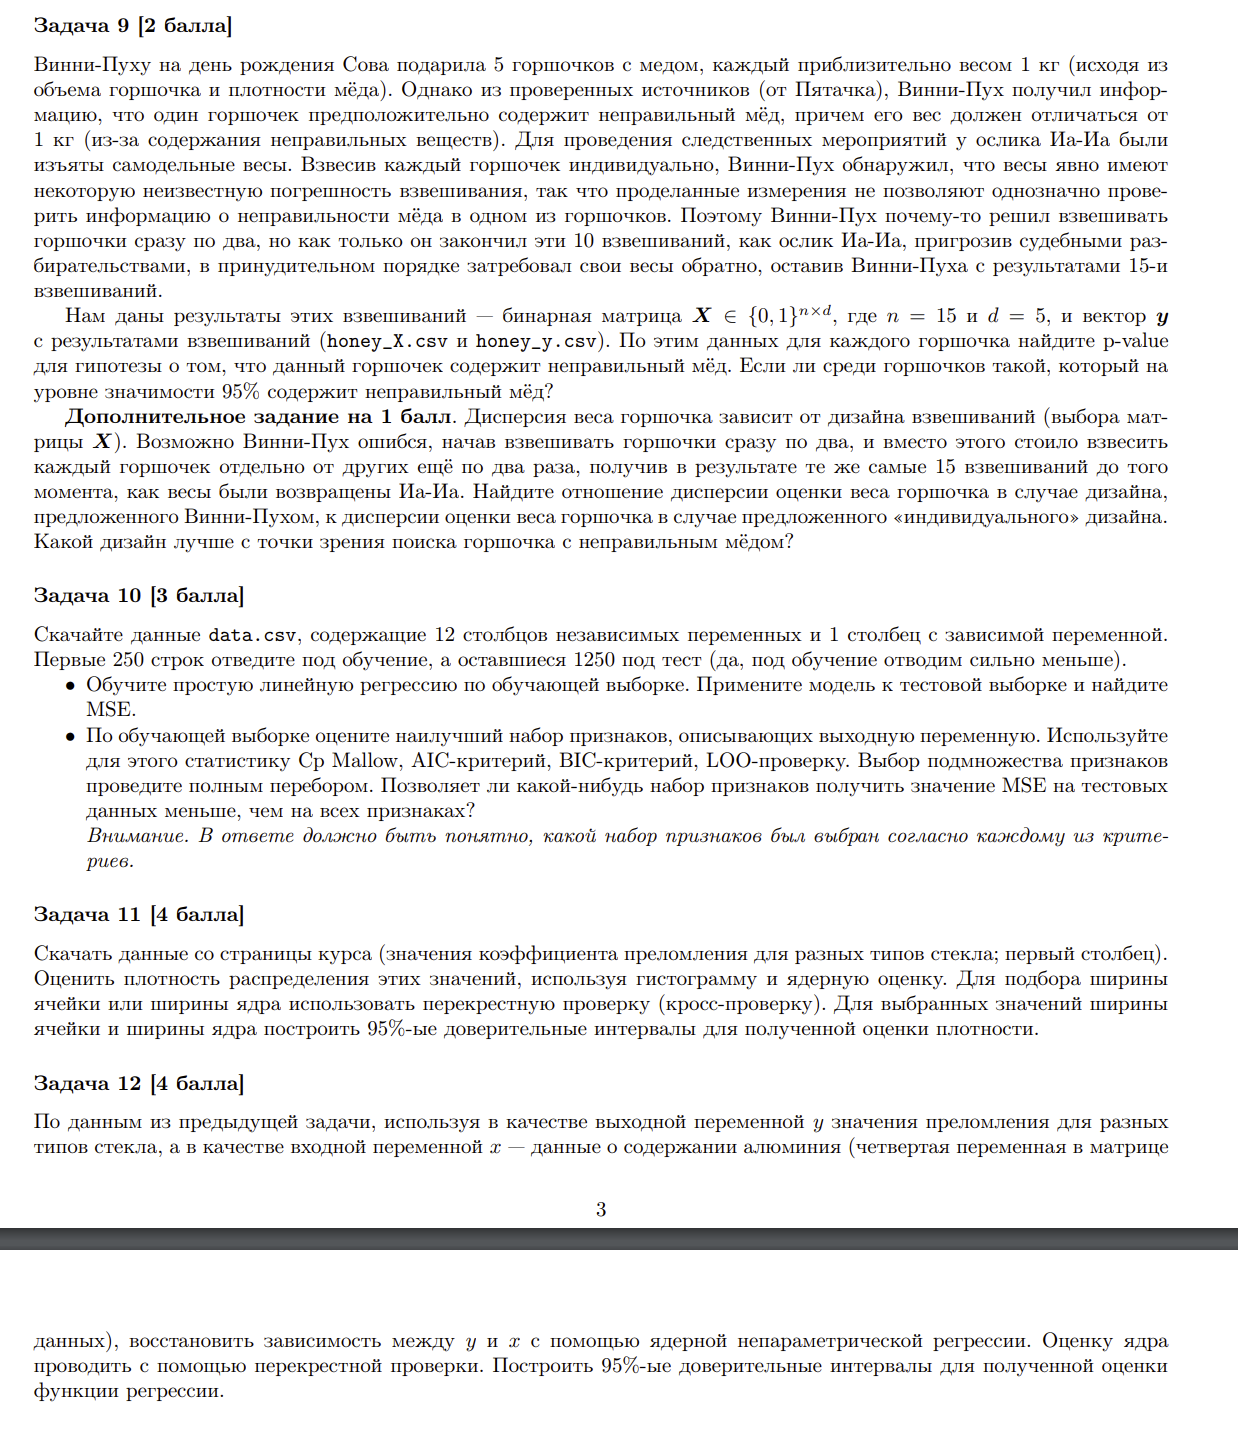

### Задача 9

In [5]:
X = pd.read_csv('honey_X.csv')
y = pd.read_csv('honey_y.csv')

In [6]:
X = X.drop('Unnamed: 0', axis=1)
X

,0,1,2,3,4
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0
5,1.0,1.0,0.0,0.0,0.0
6,1.0,0.0,1.0,0.0,0.0
7,1.0,0.0,0.0,1.0,0.0
8,1.0,0.0,0.0,0.0,1.0
9,0.0,1.0,1.0,0.0,0.0


In [7]:
y = y.drop('Unnamed: 0', axis=1)
y

,0
0,1.075063
1,1.007503
2,1.018630
3,1.028259
4,0.964053
5,1.992328
6,1.959058
7,1.978497
8,1.929246
9,1.992317


Смотрим на модель из коробки

In [34]:
import statsmodels.api as sm

model = sm.OLS(y['0'], X)
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      0   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                              7016.
Date:                Sun, 23 Apr 2023   Prob (F-statistic):                    2.20e-17
Time:                        18:51:35   Log-Likelihood:                          31.848
No. Observations:                  15   AIC:                                     -53.70
Df Residuals:                      10   BIC:                                     -50.16
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

C:\Users\Решин Кирилл\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Доверительный интервал для последнего горшка - (0.92, 0.99), то есть он единственный не захватывает единичку и является искомым горшочком с неправильным медом (при уровне доверия 95%)

In [56]:
def find_weights(X, y):
    """Finds the OLS/MLE weights estimate for multivariate linear regression model

    :param X: Matrix (np.ndarray) of shape (N, D) where N is number of objects and D is
        dimensionality of an object's feature vector
    :param y: Matrix of known dependent variables
    """
    assert X.ndim == 2 and y.ndim == 1
    assert X.shape[0] == y.shape[0]
    return np.linalg.inv(np.dot(X.T, X)).dot(X.T).dot(y)


class LinearRegression(object):
    def __init__(self, fit_intercept=True):
        super(LinearRegression, self).__init__()
        self._fit_intercept = fit_intercept
        self._weights = None
        
    def fit(self, X, y):
        X = np.array(X, dtype=np.float64, copy=False)
        N, D = X.shape
        assert N > D

        if self._fit_intercept:
            X = np.hstack([X, np.ones((N, 1))])
            D += 1

        assert X.shape == (N, D)
        assert y.shape == (N,)

        self._weights = find_weights(X, y)
        self._sigma2 = np.sum((np.dot(X, self._weights) - y)**2) / (N - D)
        self._covariance = self._sigma2 * np.linalg.inv(np.dot(X.T, X))
    
    def RSS(self, X, y):
        if self._fit_intercept:
            N = X.shape[0]
            X = np.hstack([X, np.ones((N, 1))])
        return np.sum((np.dot(X, self._weights) - y)**2)
    
    def MSE(self, X, y):
        return self.RSS(X, y) / X.shape[0]

    def predict(self, X):
        if self._fit_intercept:
            N = X.shape[0]
            X = np.hstack([X, np.ones((N, 1))])
        return np.dot(X, self._weights)
    
    @property
    def weights(self):
        return self._weights
    
    @property
    def sigma2(self):
        return self._sigma2
    
    @property
    def covariance(self):
        return self._covariance
    
    @property
    def variances(self):
        D = self._covariance.shape[0]
        return self._covariance[np.arange(D), np.arange(D)]
    
    @property
    def p_values(self):
        means = self.weights
        variances = self.variances
        p_values = 2 * scipy.stats.norm.sf(np.abs(self.weights - 1) / np.sqrt(variances))
        return p_values

In [57]:
lin_regr = LinearRegression(fit_intercept=False)
lin_regr.fit(X, y['0'])
print('weights =', lin_regr.weights)
print('sigma =', np.sqrt(lin_regr.sigma2))
print('weights deviations =', np.sqrt(lin_regr.variances))
print('p_values =', lin_regr.p_values)

weights = [0.99615236 1.00436206 0.97879489 1.00892409 0.96134952]
sigma = 0.03545735171265297
weights deviations = [0.01671476 0.01671476 0.01671476 0.01671476 0.01671476]
p_values = [0.81794085 0.79411506 0.20456742 0.59340745 0.02075804]


p-value < 0.05 только для последнего горшочка, то есть на уровне значимости 95% он содержит неправильный мед

In [42]:
str(lin_regr.weights + 1.96 * np.sqrt(lin_regr.variances)) + ' - right bounds'

'[1.02891328 1.03712298 1.01155582 1.04168501 0.99411045] - right bounds'

In [43]:
str(lin_regr.weights - 1.96 * np.sqrt(lin_regr.variances)) + ' - left bounds'

'[0.96339144 0.97160114 0.94603397 0.97616317 0.9285886 ] - left bounds'

Получили те же доверительные интервалы, что нам уже выдавала модель из коробки

Получаем, что про пятый горшочек можно сказать, что он содержит неправильный мед (на уровне значимости 0.95)

### Задача 10

In [4]:
data = pd.read_csv('data.csv')
data = data.drop('Unnamed: 0', axis=1)
data.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,y
0,-0.005962,0.002994,0.010311,0.003520,0.013630,0.001249,0.010056,0.002682,-0.000644,0.030599,-0.018424,0.012567,0.799789
1,-0.010517,0.000928,-0.003034,0.005389,-0.015157,-0.025433,0.003349,-0.011916,-0.012691,0.005594,0.018555,-0.008537,-2.102527
2,0.026343,-0.009401,-0.001616,-0.013509,-0.008762,0.000278,-0.011721,-0.014114,-0.026160,-0.011977,0.020331,-0.023739,6.356173
3,0.023210,-0.013601,0.001653,0.010330,0.010953,-0.020146,0.004575,-0.014586,-0.016518,-0.011041,0.020122,-0.015881,-3.128945
4,-0.013655,-0.008853,-0.007225,-0.014653,0.001229,-0.024574,-0.008257,-0.014607,0.008607,0.010026,-0.006604,0.014465,-6.639211


In [5]:
data.shape

(2500, 13)

In [34]:
train = data.iloc[0:250]
test = data.iloc[250:1500]
X_train = train.drop('y', axis = 1).values
X_test = test.drop('y', axis = 1).values
y_train = train.y.values
y_test = test.y.values

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
import math

In [36]:
regression = LinearRegression()
regression = regression.fit(X_train, y_train)
pred = regression.predict(X_test)
mean_squared_error(y_test, pred)

8.526523275647772

In [37]:
def cp_mallow(S):
    X = X_train[:, S]
    reg = LinearRegression().fit(X, y_train)
    return np.sum((y_train - reg.predict(X))**2) + 2 * (np.mean((y_train - regression.predict(X_train))**2)) * len(S)

In [38]:
def AIC(S):
    X = X_train[:, S]
    reg = LinearRegression().fit(X, y_train)
    eps = y_train - reg.predict(X)
    sigma_S = (np.mean(eps**2))**0.5
    return np.sum(np.log(stats.norm.pdf(eps / sigma_S) / sigma_S)) - len(S)

In [39]:
def BIC(S):
    X = X_train[:, S]
    reg = LinearRegression().fit(X, y_train)
    eps = y_train - reg.predict(X)
    sigma_S = (np.mean(eps**2))**0.5
    return np.sum(np.log(stats.norm.pdf(eps / sigma_S) / sigma_S)) - math.log(len(X_train)) * len(S) / 2

In [40]:
def LOO(S):
    X = X_train[:, S]
    reg = LinearRegression().fit(X, y_train)
    Y = reg.predict(X)
    U = X @ np.linalg.inv(X.T @ X) @ X.T
    return np.sum(((y_train - Y) / (1 - U.diagonal()))**2)

In [41]:
import itertools

def get_subsets(S):
    for l in range(len(S) + 1):
        yield from itertools.combinations(S, l)

In [42]:
def check_min(func):
    best_S = None
    best_val = None
    for subset in get_subsets(range(X_train.shape[1])):
        if len(subset) == 0:
            continue
        val = func(subset)
        if best_val is None or val <= best_val:
            best_val = val
            best_S = subset
    return best_S, best_val

In [43]:
def check_max(func):
    best_S = None
    best_val = None
    for subset in get_subsets(range(X_train.shape[1])):
        if len(subset) == 0:
            continue
        val = func(subset)
        if best_val is None or val >= best_val:
            best_val = val
            best_S = subset
    return best_S, best_val

In [44]:
def mse(S):
    X = X_train[:, S]
    reg = LinearRegression().fit(X, y_train)
    return mean_squared_error(reg.predict(X_test[:, S]), y_test)

In [45]:
S, val = check_min(cp_mallow)
S, val, mse(S)

((0, 7, 9), 2817.306297929862, 8.560073084888998)

In [46]:
S, val = check_max(AIC)
S, val, mse(S)

((0, 7, 9), -657.578459661728, 8.560073084888998)

In [47]:
S, val = check_max(BIC)
S, val, mse(S)

((0, 7), -661.1893470716379, 8.525958379211103)

In [48]:
S, val = check_min(LOO)
S, val, mse(S)

((0, 7, 9), 2819.617673795115, 8.560073084888998)

BIC нам дал самый хороший набор признаков: на признаках 0 и 7 качество выходит немного получше, чем на всех признаках.

### Задача 11

In [281]:
X = pd.read_csv('glass.dat')
X.head()

,RI Na Mg Al Si K Ca Ba Fe type
0,1 3.01 13.64 4.49 1.10 71.78 0.06 8.75 0.0...
1,2 -0.39 13.89 3.60 1.36 72.73 0.48 7.83 0.0...
2,3 -1.82 13.53 3.55 1.54 72.99 0.39 7.78 0.0...
3,4 -0.34 13.21 3.69 1.29 72.61 0.57 8.22 0.0...
4,5 -0.58 13.27 3.62 1.24 73.08 0.55 8.07 0.0...


In [70]:
X.columns

Index(['       RI    Na   Mg   Al    Si    K    Ca   Ba   Fe  type'], dtype='object')

In [282]:
X = np.array(X['       RI    Na   Mg   Al    Si    K    Ca   Ba   Fe  type'].apply(lambda x: float(x.split()[1])))

In [284]:
X[:5]

array([ 3.01, -0.39, -1.82, -0.34, -0.58])

Функции создания бинов и вычисления риска

In [285]:
def create_binedges(center, bandwidth, x_left, x_right):
    """
    Функция для удобного создания бинов заданной ширины и с заданным положением центра одного из бинов
    :param center: Значение центра одного из бинов
    :param bandwidth: Ширина бина
    :param x_left: Значение левой границы самого левого бина не больше x_left
    :param x_right: Значение правой границы самого правого бина не меньше x_right
    """
    bins = [center - bandwidth / 2]
    while x_left < bins[-1]:
        bins.append(bins[-1] - bandwidth)
    bins = list(reversed(bins))
    while x_right > bins[-1]:
        bins.append(bins[-1] + bandwidth)
    return bins


def histogram_pdf_estimated_risk(bincounts, bandwidth=None, n_bins=None):
    h = bandwidth
    n = np.sum(bincounts)
    ps = bincounts / n
    return 2 / ((n - 1) * h) - ((n + 1.0) / (h * (n - 1.0))) * np.sum(ps ** 2)

PDF для некоторой ширины бина

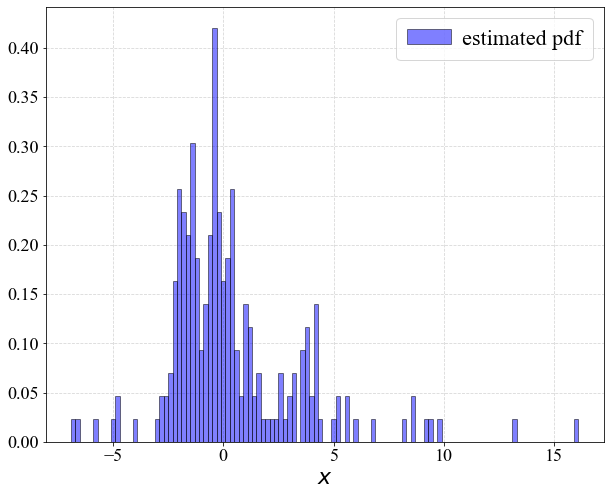

In [286]:
bandwidth = 0.2
binedges = create_binedges(0., bandwidth, X.min(), X.max())

plt.figure(figsize=(10, 8))
plt.hist(X, bins=binedges, color='b', density=True, edgecolor='k', 
         label='estimated pdf', alpha=0.5, zorder=2)
plt.xlabel(r'$x$')
plt.legend()
plt.grid(which='both', linestyle='--', alpha=0.5)

Функция оценки риска в зависимости от ширины бина

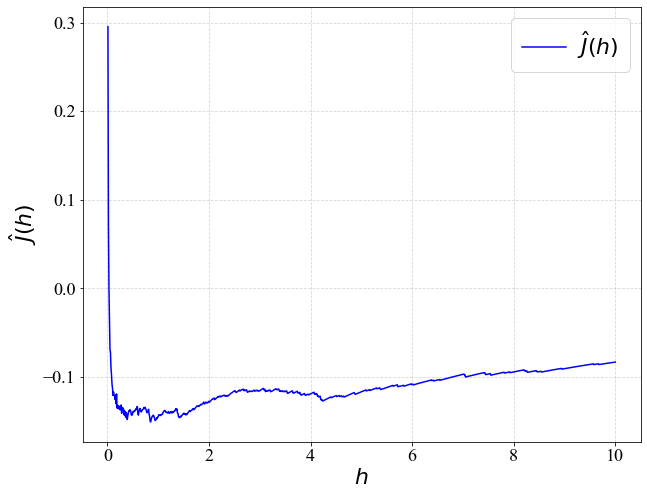

In [287]:
bandwidth_range = np.linspace(0.01, 10, 1000)
risk_values = []
for bandwidth in bandwidth_range:
    binedges = create_binedges(0., bandwidth, X.min(), X.max())
    bincounts, _ = np.histogram(X, bins=binedges)
    risk_values.append(histogram_pdf_estimated_risk(bincounts, bandwidth))
risk_values = np.array(risk_values)

plt.figure(figsize=(10, 8))
plt.plot(bandwidth_range, risk_values, color='b', label=r'$\hat{J}(h)$', zorder=2);
plt.xlabel(r'$h$'); plt.ylabel(r'$\hat{J}(h)$')
plt.legend();
plt.grid(which='both', linestyle='--', alpha=0.5);

Вычисляем оптимальную ширину бина

In [288]:
index_min = np.argmin(risk_values)
opt_bandwidth = bandwidth_range[index_min]
min_risk = risk_values[index_min]
print('h = {}, J = {}'.format(opt_bandwidth, min_risk))

h = 0.85, J = -0.15101950995817837


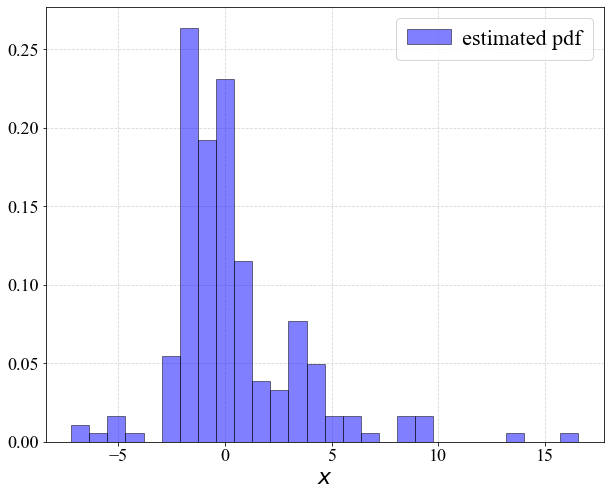

In [289]:
binedges = create_binedges(0, opt_bandwidth, X.min(), X.max())
plt.figure(figsize=(10, 8))
plt.hist(X, bins=binedges, color='b', density=True, edgecolor='k', 
         label='estimated pdf', alpha=0.5, zorder=2)
plt.xlabel(r'$x$')
plt.legend()
plt.grid(which='both', linestyle='--', alpha=0.5)

Строим доверительную трубку по формулам с лекции

In [290]:
alpha = 0.95
n = len(X)
m = len(binedges)
c = - stats.norm().ppf(alpha/(2 * m)) * np.sqrt(m / n) / 2
c

0.3929759264923584

In [228]:
l_n = np.sqrt(np.histogram(X, bins=binedges)[0]) - c
l_n[l_n < 0] = 0
l_n = l_n ** 2
u_n = (np.sqrt(np.histogram(X, bins=binedges)[0]) + c) ** 2

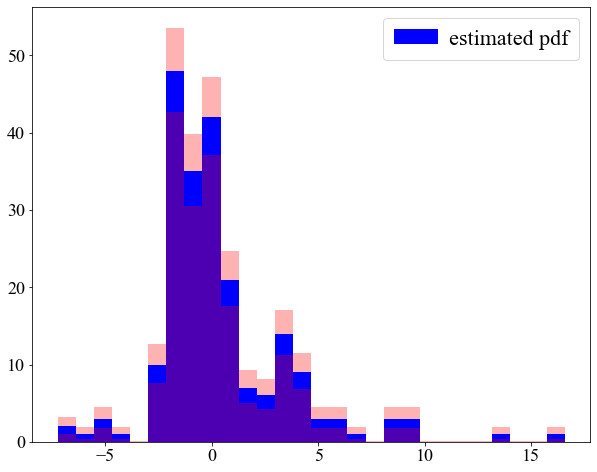

In [246]:
counts, bins = np.histogram(X, bins=binedges)
plt.stairs(u_n, bins, alpha=0.3, color='r', fill=True)
plt.stairs(counts, bins, color='b', fill=True, label='estimated pdf')
plt.stairs(l_n, bins, alpha=0.3, color='r', fill=True)
plt.legend()
plt.show()

Теперь построим ядерную оценку

Функция для вычисления риска

In [291]:
def gaussian_kernel_estimated_risk(samples, bandwidth):
    """Calculates the risk for gaussian kernel

    :param samples: 1D numpy array with samples
    :param bandwidth: bandwidth parameter of gaussian kernel

    :rtype: float
    :returns: Estimated risk value
    """
    X = samples
    h = bandwidth
    n = len(X)
    Jh = 0
    Xi = X[None, :]
    Xj = X[:, None]
    points = (Xi - Xj) / h
    Jh = np.sum(stats.norm.pdf(points, loc=0, scale=np.sqrt(2))) -\
        2 * np.sum(stats.norm.pdf(points, loc=0, scale=1))
    Jh /= h * (n**2)
    Jh += (2.0 / (h * n)) * stats.norm.pdf(0, loc=0, scale=1)
    return Jh

Ядерная оценка для некторой ширины ядра

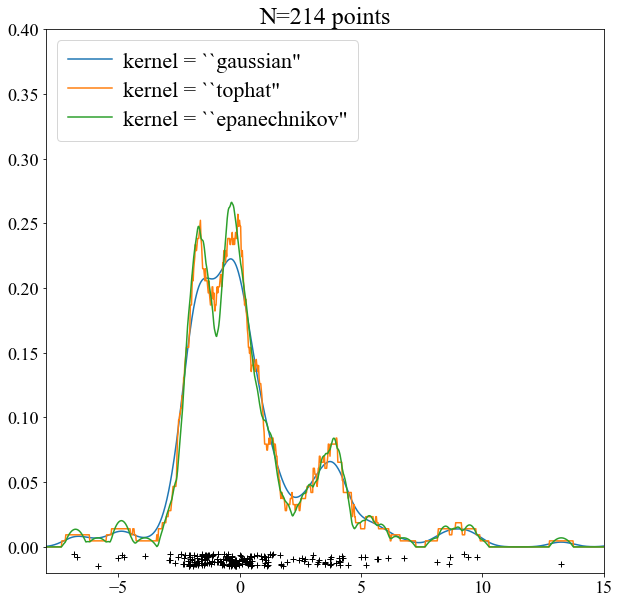

In [292]:
n_samples = len(X)
x_values = np.linspace(-8, 15, 1000)
binedges = np.linspace(-8, 15, 10)

fig, ax = plt.subplots(figsize=(10, 10))

for kernel in ['gaussian', 'tophat', 'epanechnikov']:
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X[:,None])
    log_dens = kde.score_samples(x_values[:, None])
    ax.plot(x_values, np.exp(log_dens), '-', label="kernel = ``{0}\"".format(kernel))

ax.set_title("N={0} points".format(n_samples))

ax.legend(loc='upper left')
ax.plot(X, -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-8, 15)
ax.set_ylim(-0.02, 0.4)
plt.show()

Функция оценки риска зависимости от размера ядра

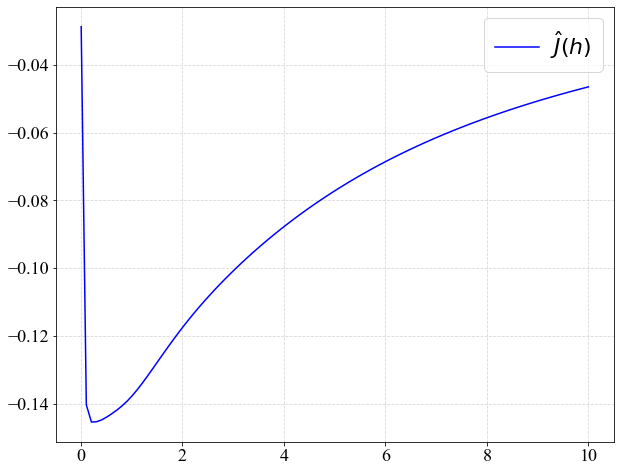

In [293]:
bandwidth_range = np.linspace(0.01, 10, 100)
risk_values = []
for bandwidth in bandwidth_range:
    risk_values.append(gaussian_kernel_estimated_risk(X, bandwidth))
risk_values = np.array(risk_values)

plt.figure(figsize=(10, 8))
plt.plot(bandwidth_range, risk_values, color='b', label=r'$\hat{J}(h)$', zorder=2);
plt.legend();
plt.grid(which='both', linestyle='--', alpha=0.5);

Вычисляем оптимальную ширину

In [294]:
index_min = np.argmin(risk_values)
opt_bandwidth = bandwidth_range[index_min]
min_risk = risk_values[index_min]
print('h = {}, J = {}'.format(opt_bandwidth, min_risk))

h = 0.21181818181818182, J = -0.14547023406344872


PDF для оптимальной ширины ядра

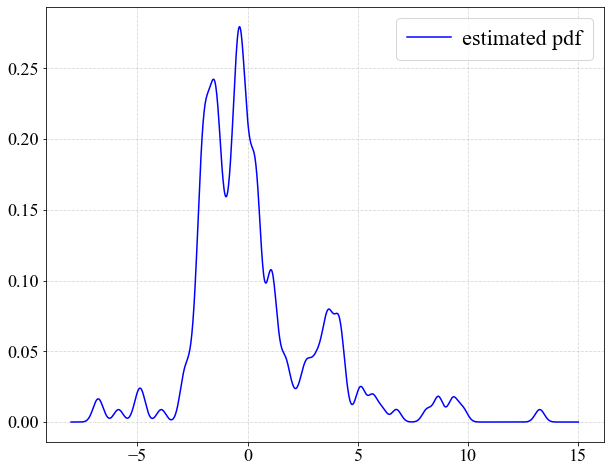

In [295]:
kde = KernelDensity(bandwidth=opt_bandwidth)
kde.fit(X[:,None])
pdf = np.exp(kde.score_samples(x_values[:,None]))

plt.figure(figsize=(10, 8))
plt.plot(x_values, pdf, color='b', label='estimated pdf', zorder=2);
plt.legend();
plt.grid(which='both', linestyle='--', alpha=0.5);

Строим доверительную трубку

In [296]:
class GaussianKernel:
    def __init__(self, loc=0, scale=1):
        self.loc = loc
        self.scale = scale

    def __call__(self, x):
        return stats.norm.pdf(x, loc=self.loc, scale=self.scale)

In [298]:
alpha = 0.95
h = opt_bandwidth
n = len(X)

a = X.min()
b = X.max()
m = (b - a) / (3 * h)
q = scipy.stats.norm.ppf((1 + (1 - alpha)**(1 / m)) / 2.)
kernel = GaussianKernel()
Y = 1 / h * kernel((x_values[:, None] - X[None, :]) / h)
s2 = n / (n - 1) * Y.var()
se = np.sqrt(s2) / np.sqrt(n)
lower = pdf - q * se
upper = pdf + q * se

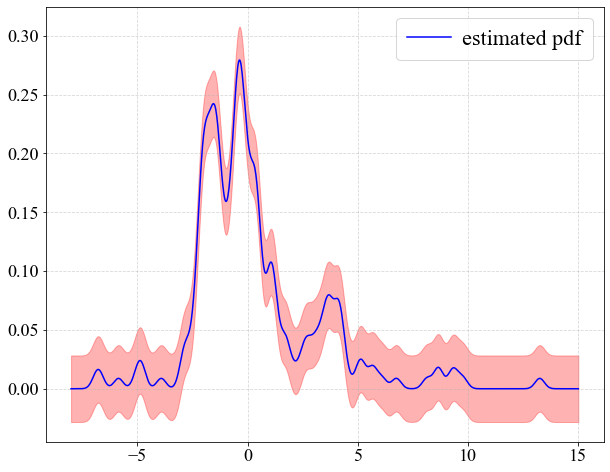

In [299]:
plt.figure(figsize=(10, 8))
plt.plot(x_values, pdf, color='b', label='estimated pdf', zorder=2);
plt.fill_between(x_values, lower, upper, alpha=0.3, color='r') 
plt.legend();
plt.grid(which='both', linestyle='--', alpha=0.5);
plt.show()

### Задача 12

In [264]:
data = pd.read_csv('glass.dat')
data.head()

,RI Na Mg Al Si K Ca Ba Fe type
0,1 3.01 13.64 4.49 1.10 71.78 0.06 8.75 0.0...
1,2 -0.39 13.89 3.60 1.36 72.73 0.48 7.83 0.0...
2,3 -1.82 13.53 3.55 1.54 72.99 0.39 7.78 0.0...
3,4 -0.34 13.21 3.69 1.29 72.61 0.57 8.22 0.0...
4,5 -0.58 13.27 3.62 1.24 73.08 0.55 8.07 0.0...


Извлекаем данные

In [273]:
Y = np.array(data['       RI    Na   Mg   Al    Si    K    Ca   Ba   Fe  type'].apply(lambda x: float(x.split()[1])))
X = np.array(data['       RI    Na   Mg   Al    Si    K    Ca   Ba   Fe  type'].apply(lambda x: float(x.split()[4])))

In [274]:
class GaussianKernel:
    def __init__(self, loc=0, scale=1):
        self.loc = loc
        self.scale = scale

    def __call__(self, x):
        return stats.norm.pdf(x, loc=self.loc, scale=self.scale)


class NadarayaWatsonRegressor:
    def __init__(self, kernel, bandwidth):
        self.kernel = kernel
        self.bandwidth = bandwidth

    def fit(self, X, Y):
        self.X = np.array(X)
        self.Y = np.array(Y)

    def predict(self, X):
        K_X = (X[:, None] - self.X[None, :]) / self.bandwidth
        K = self.kernel(K_X)
        predictions = np.sum(K * Y[None, :], axis=1) / np.sum(K, axis=1)
        return predictions


def nw_regression_estimated_risk(X, Y, bandwidth, kernel=None):
    if kernel is None:
        kernel = GaussianKernel()
    h = bandwidth
    nw_regressor = NadarayaWatsonRegressor(GaussianKernel(), h)
    nw_regressor.fit(X, Y)
    Y_pred = nw_regressor.predict(X)
    K_X = (X.reshape((-1, 1)) - X.reshape((1, -1))) / h
    K = kernel(K_X)
    K_sums = np.sum(K, axis=1)
    J = np.sum((((Y - Y_pred) * K_sums) / (K_sums - kernel(0)))**2)
    return J

Смотрим на регрессию с рандомной шириной ядра

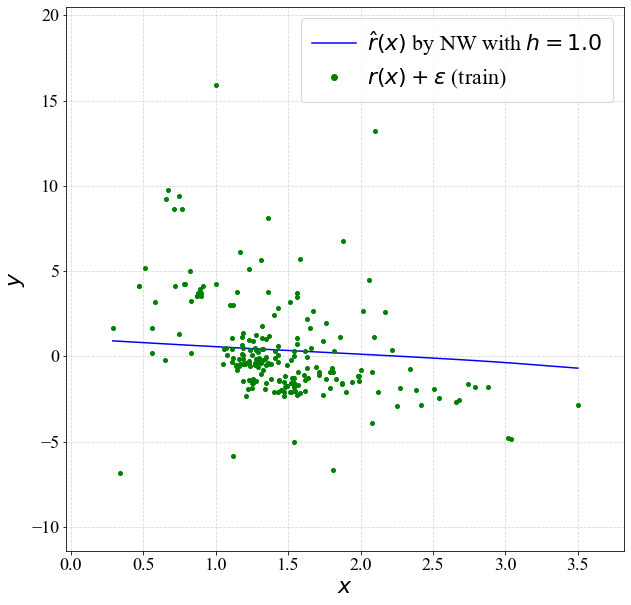

In [276]:
bandwidth = 1.
nw_regressor = NadarayaWatsonRegressor(GaussianKernel(), bandwidth)
indices = np.argsort(X)
X = X[indices]
Y = Y[indices]
nw_regressor.fit(X, Y)
Y_pred = nw_regressor.predict(X)

plt.figure(figsize=(10, 10))
plt.plot(X, Y_pred, color='b', label='$\hat{{r}}(x)$ by NW with $h = {}$'.format(bandwidth), zorder=2)
plt.plot(X, Y, color='g', marker='o', markersize=4, linestyle='none', label=r'$r(x) + \varepsilon$ (train)',
         zorder=2)
plt.legend()
plt.xlabel('$x$');
plt.ylabel('$y$');
x_span = X.max() - X.min()
y_span = Y.max() - Y.min() 
plt.xlim([X.min() - 0.1 * x_span, X.max() + 0.1 * x_span])
plt.ylim([Y.min() - 0.2 * y_span, Y.max() + 0.2 * y_span])
plt.grid(which='both', linestyle='--', alpha=0.5);

Подбираем оптимальную ширину ядра

h=0.13, J(h)=1466.9099608384945


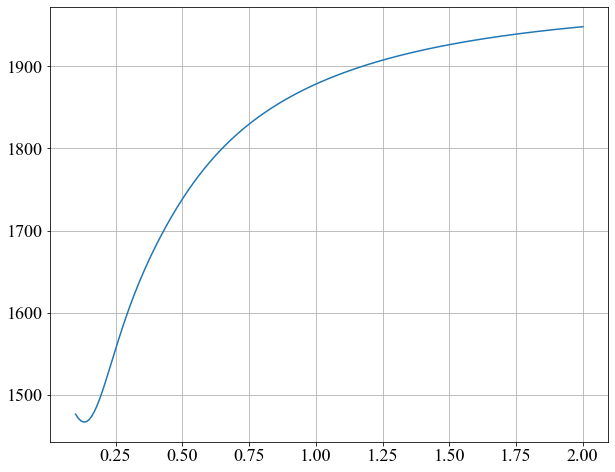

In [277]:
bandwidth_values = np.linspace(0.1, 2, 191)

estimated_risks = []
for bandwidth in bandwidth_values:
    risk = nw_regression_estimated_risk(X, Y, bandwidth, kernel=GaussianKernel())
    estimated_risks.append(risk)

bandwidth_opt = bandwidth_values[np.argmin(estimated_risks)]
print(f'h={bandwidth_opt}, J(h)={estimated_risks[np.argmin(estimated_risks)]}')

plt.plot(bandwidth_values, estimated_risks)
plt.grid();

Строим доверительную трубку

In [278]:
alpha = 0.95
h = bandwidth_opt
n = len(X)

a = X.min()
b = X.max()
m = (b - a) / (3 * h)
q = scipy.stats.norm.ppf((1 + (1 - alpha)**(1 / m)) / 2.)
sigma = np.sqrt(np.sum((Y[1:] - Y[:-1])**2) / (2 * (n - 1)))

x_values = np.linspace(a, b, 1001)
kernel = GaussianKernel()
K = kernel((x_values[:, None] - X[None, :]) / h)
W = K / K.sum(axis=1)[:, None]
se = sigma * np.sqrt(np.sum(W ** 2, axis=1))

Y_pred = np.sum(W * Y[None, :], axis=1)
lower = Y_pred - q * se
upper = Y_pred + q * se

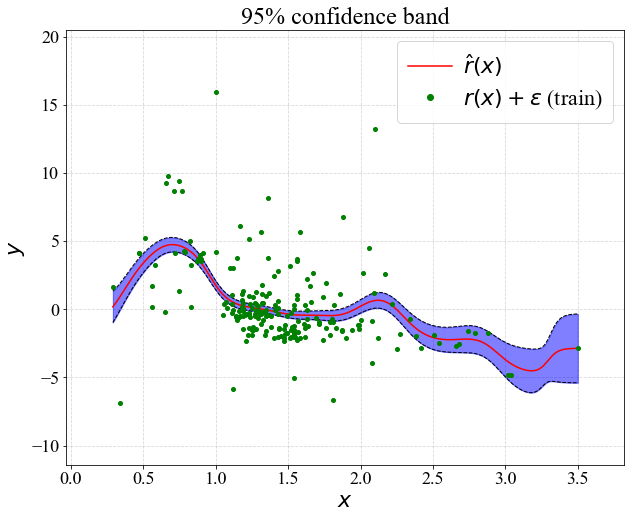

In [280]:
plt.figure(figsize=(10, 8))
plt.fill_between(x_values, lower, upper, color='b', alpha=0.5, zorder=2)
plt.plot(x_values, lower, color='k', linewidth=1, linestyle='--')
plt.plot(x_values, upper, color='k', linewidth=1, linestyle='--')
plt.plot(x_values, Y_pred, color='r', label=r'$\hat{r}(x)$')
plt.plot(X, Y, color='g', marker='o', markersize=4, linestyle='none', label=r'$r(x) + \varepsilon$ (train)')

# Limits
x_span = X.max() - X.min()
y_span = Y.max() - Y.min() 
plt.xlim([X.min() - 0.1 * x_span, X.max() + 0.1 * x_span])
plt.ylim([Y.min() - 0.2 * y_span, Y.max() + 0.2 * y_span])

# Labels
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('95% confidence band')

plt.legend()
plt.grid(which='both', alpha=0.5, linestyle='--');